# Research Question No. 2

## How frequent are long-lived bugs in FLOSS project?

## Experimental parameters


| Project                    |         #Reports     |       #Thesholds     |
|----------------------------|:--------------------:|:--------------------:|
| Eclipse                    |        9998         |         365          |
| GCC                        |        9998         |         365          |
| Gnome                      |        7991          |         365          |
| Freedesktop                |        7712          |         365          |
| Mozilla                    |        9998          |         365          |
| WineHQ                     |        6073          |         365          |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup environment.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string
import re

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup Seaborn
sns.set_context("paper")
sns.set(style="ticks", color_codes=True, font_scale=2)

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE  = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font',   size=SMALL_SIZE)       # controls default text sizes
plt.rc('axes',   titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes',   labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
#%matplotlib inline 

# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
projects = ['eclipse', 'freedesktop', 'gnome', 'mozilla', 'gcc', 'winehq']

# Fixed time threshold.
bug_reports_file_prefix  = '20190917'
bug_fix_time_threshold   = 365
print("Setup complete")

[nltk_data] Downloading package punkt to /home/gomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gomes/nltk_data...


Setup complete


[nltk_data]   Package stopwords is already up-to-date!


## Step 2. Load data.

In [3]:
bug_reports_data_list = []
for project in projects:
    bug_reports_path = f"datasets/{bug_reports_file_prefix}_{project}_bug_report_data.csv"

    # read bug reports data.
    bug_reports_data = pd.read_csv(bug_reports_path)[0:10000]
    rows_and_cols = bug_reports_data.shape
    print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {bug_reports_path}.\n")
    print(f"Mean of bug fix time: {bug_reports_data['bug_fix_time'].mean(axis=0)}.\n")
   
    bug_reports_data["project"] = project  
    bug_reports_data_list.append(bug_reports_data) 

# concatenate all bug_reports_data 
bug_reports_all_data = pd.concat(bug_reports_data_list)

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

Mean of bug fix time: 108.5303.

There are 7714 rows and 19 columns in datasets/20190917_freedesktop_bug_report_data.csv.

Mean of bug fix time: 173.19665543168264.

There are 7993 rows and 19 columns in datasets/20190917_gnome_bug_report_data.csv.

Mean of bug fix time: 202.4147378956587.

There are 10000 rows and 19 columns in datasets/20190917_mozilla_bug_report_data.csv.

Mean of bug fix time: 278.071.

There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

Mean of bug fix time: 337.8563.

There are 6074 rows and 19 columns in datasets/20190917_winehq_bug_report_data.csv.

Mean of bug fix time: 491.10273296015805.



## Step 3. Preprocess data.

In [4]:
def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=set()
    for word in token_words:
        stem_sentence.add(stemmer.stem(word))
        
    return ' '.join(list(stem_sentence))

def clean_text(text):
    """Clean a text.

    Parameters
    ----------
    text: string
        A text string.

    Returns
    -------
    text:string
        A modified initial text string
    """
    if text != text:
        return ' '

    replace_by_space = re.compile("[/(){}\[\]\|@,;]")
    replace_bad_symbols = re.compile('[^0-9a-z #+_]')
    english_stopwords = set(stopwords.words('english'))
    text = text.lower()
    text = replace_by_space.sub(' ', text)
    text = replace_bad_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in english_stopwords)
    return stem_sentence(text)

def get_file_size(project, bugid):
    bugid = re.findall(r"\d+$", bugid)[0]
    file_name=f"/home/gomes/Workspace/doctorate/data/{project}/xml/{project.upper()}-{bugid}.xml"
    info = os.stat(file_name) 
    return info.st_size * 0.000001
    

In [5]:
bug_reports_path = f"datasets/{bug_reports_file_prefix}_bug_reports_all_data.csv"
if (not os.path.exists(bug_reports_path)):
    bug_reports_all_data['short_description'] = bug_reports_all_data['short_description'].fillna(" ")
    bug_reports_all_data['long_description']  = bug_reports_all_data['long_description'].fillna(" ")
    #bug_reports_all_data['short_description_words'] = bug_reports_all_data['short_description'].apply(lambda s: len(clean_text(s).split()))
    #bug_reports_all_data['long_description_words']  = bug_reports_all_data['long_description'].apply(lambda s: len(clean_text(s).split()))
    bug_reports_all_data['long_lived?']  = bug_reports_all_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > bug_fix_time_threshold else 'short-lived')

    bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['severity_category'] == 'not set'].index, inplace=True)
    bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['bug_fix_time'] < 0 ].index, inplace=True)

    #bug_reports_all_data = pd.read_csv(bug_reports_path)
    #bug_reports_dir   = os.path.join('/home/gomes/Workspace/doctorate/data/eclipse/xml/')
    #bug_reports_files = os.listdir(bug_reports_dir)
    #bug_reports_all_data['file_size'] = bug_reports_all_data.apply(lambda x: get_file_size(x['project'], x['bug_id']), axis=1)
    #bug_reports_all_data.nlargest(10, 'file_size')

    bug_reports_all_data.to_csv(bug_reports_path, index=False)
else:
    print(f"{bug_reports_path} exists, read data from it!")
    bug_reports_all_data = pd.read_csv(bug_reports_path)



datasets/20190917_bug_reports_all_data.csv exists, read data from it!


## Step 3. Exploring data analysis

In [6]:
bug_reports_all_data['project'].value_counts()

mozilla        9998
gcc            9998
eclipse        9998
gnome          7991
freedesktop    7712
winehq         6073
Name: project, dtype: int64

In [7]:
bug_reports_all_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,long_lived?
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,...,6,2012-09-21,0,5,2011-08-10,0,normal,2,eclipse,short-lived
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,...,4,2010-03-03,0,6,2009-04-29,177,normal,2,eclipse,short-lived
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,...,4,2011-03-02,0,5,2011-03-02,1,normal,2,eclipse,short-lived
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,...,4,2010-03-24,0,7,2006-08-29,50,major,4,eclipse,short-lived
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,...,4,2013-04-02,0,3,2013-04-02,264,critical,5,eclipse,short-lived


In [8]:
bug_reports_all_data.loc[bug_reports_all_data['project']=='gcc'].nlargest(1, 'bug_fix_time')

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,long_lived?
41728,GCC-9,2000-02-29,c++,GCC,local class and -O1,[Original report in ]\nI'm not sure if this a ...,jason,martin,fixed,1,...,4,2019-01-18,0,10,2019-01-18,6898,normal,2,gcc,long-lived


In [9]:
from numpy import percentile
for project in projects:
    display(project)
    bug_reports_data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    display(bug_reports_data['bug_fix_time'].describe())
    q25, q75 = percentile(bug_reports_data['bug_fix_time'], 25), percentile(bug_reports_data['bug_fix_time'], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    outliers =  [x for x in bug_reports_data['bug_fix_time'] if x < lower or x > upper]
    # identify outliers
    outliers = [x for x in bug_reports_data['bug_fix_time'] if x < lower or x > upper]
    print('Identified outliers: %.3f' % (len(outliers)/len(bug_reports_data)*100))

'eclipse'

count    9998.000000
mean      108.538708
std       317.687949
min         0.000000
25%         1.000000
50%         8.000000
75%        63.000000
max      4961.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=1.000, 75th=63.000, IQR=62.000
Identified outliers: 15.203


'freedesktop'

count    7712.000000
mean      173.236385
std       384.633005
min         0.000000
25%         3.000000
50%        28.000000
75%       162.000000
max      4896.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=3.000, 75th=162.000, IQR=159.000
Identified outliers: 12.254


'gnome'

count    7991.000000
mean      202.465524
std       475.371999
min         0.000000
25%         2.000000
50%        23.000000
75%       162.000000
max      5577.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=2.000, 75th=162.000, IQR=160.000
Identified outliers: 13.302


'mozilla'

count    9998.000000
mean      278.055011
std       661.505883
min         0.000000
25%         3.000000
50%        24.000000
75%       187.750000
max      7294.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=3.000, 75th=187.750, IQR=184.750
Identified outliers: 15.503


'gcc'

count    9998.000000
mean      337.904081
std       591.241826
min         0.000000
25%         5.000000
50%        63.000000
75%       475.000000
max      6898.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=5.000, 75th=475.000, IQR=470.000
Identified outliers: 6.181


'winehq'

count    6073.00000
mean      491.18327
std       667.48611
min         0.00000
25%        22.00000
50%       220.00000
75%       709.00000
max      5636.00000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=22.000, 75th=709.000, IQR=687.000
Identified outliers: 6.158


In [10]:
bug_reports_all_data.groupby('project').agg({'creation_date':[np.min, np.max]})

creation_date            
                     amin        amax
project                              
eclipse        2001-10-10  2018-01-30
freedesktop    2003-02-05  2019-08-15
gcc            1999-08-26  2018-01-31
gnome          1999-01-02  2018-01-24
mozilla        1998-04-15  2014-04-22
winehq         2000-09-27  2018-04-17

### Step 4. Bug Fixing Time Distribution

<Figure size 640x480 with 0 Axes>

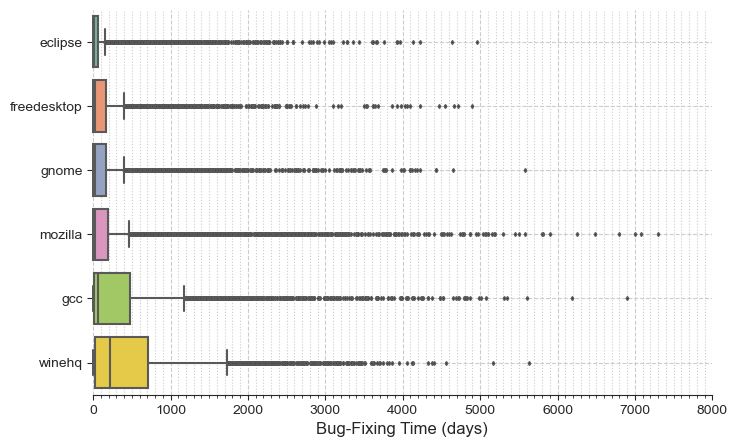

In [11]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
sns.despine(offset=10)
sns.set_style("ticks")
threshold = 8000

fig, ax = plt.subplots(figsize=(8, 5))
df = bug_reports_all_data.loc[(bug_reports_all_data["bug_fix_time"] < threshold)] 
g  = sns.boxplot(data=df, x="bug_fix_time", y="project", palette="Set2", ax=ax, showfliers = True, flierprops = dict(markerfacecolor = '.10', markersize = 2))
plt.ylabel("", fontsize= 12)
plt.xlabel("Bug-Fixing Time (days)", fontsize= 12)
plt.title("", fontsize= 15)
ax.yaxis.grid(True)
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.set(xlim=( -10, threshold))
sns.despine(trim=True, left=True)
plt.savefig(f"figures/rq2-bug-fix-time-distribution.pdf", format="pdf", dpi=600, bbox_inches='tight')

### Step 5. How frequent are long-lived bugs?

In [12]:
def plot_pyramid (data, column, filename):
  
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_n.fillna(0, inplace=True)
    
    top_n.reset_index(inplace=True)
    top_n = top_n.sort_values('long-lived', ascending=True)
    
    print(top_n)
    
    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, sharey=False, gridspec_kw = {'wspace':0, 'hspace':0})

    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True

    sns.despine(offset=0.5)
    sns.barplot(x="long-lived", y=column, color="tab:red", ax=axes[0], data=top_n)
    sns.barplot(x="short-lived", y=column,  color="tab:blue", ax=axes[1], data=top_n)
    
    axes[0].set(xlim=(0, 1))
    axes[0].invert_xaxis()
    axes[0].spines['left'].set_visible(False)
    axes[0].tick_params(axis="x", labelsize=MEDIUM_SIZE+3)
    axes[0].tick_params(axis="y", labelsize=MEDIUM_SIZE+3)
    axes[0].set_ylabel(column.title().replace("_", " ").replace("Category", "Level"), fontsize=MEDIUM_SIZE+2)
    axes[0].set_xlabel("Long-lived", fontsize=MEDIUM_SIZE+3)    
    axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
    
    axes[1].set(xlim=(0, 1))
    axes[1].set_yticks([])
    axes[1].set(ylabel="")
    axes[1].tick_params(axis="x", labelsize=MEDIUM_SIZE+3)
    axes[1].set_xlabel("Short-lived", fontsize=MEDIUM_SIZE+3)
    axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])
    
    #sns.despine(offset=0.5)
    s = axes[1].twinx()
    labels = [i.get_text() for i in axes[0].get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    s.set_yticks(axes[0].get_yticks())
    s.set_ylim(axes[0].get_ylim())
    s.set_yticklabels(labels_new)
    s.tick_params(axis="y", labelsize=MEDIUM_SIZE+3)
    
    s.spines['top'].set_visible(False)
    s.spines['bottom'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.spines['left'].set_visible(False)
        
    #fig.suptitle(project, fontsize=BIGGER_SIZE)
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')

def plot_bar (data, filename):
    
    top_g = data.groupby("project")["project"].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data['project'].isin(top_s.index)].groupby('project')['long_lived?'].value_counts(normalize=True).unstack()
    
    plt.figure(figsize=(20,20))
    fig, axis = plt.subplots(figsize=(10, 10)) 
    
    sns.despine(offset=5)
    primary   = top_n.plot(kind='barh', stacked='True',  grid='True', color=["tab:red", "tab:blue"], ax=axis)
    secondary = primary.twinx()
    
    labels = [i.get_text() for i in primary.get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    
    primary.set(xlim=(0, 1))
    primary.set_xlabel('percentage', fontsize=MEDIUM_SIZE)
    primary.set_ylabel('FLOSS Projects', fontsize=MEDIUM_SIZE) 
    primary.set_title("project", fontsize=BIGGER_SIZE)
    primary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    primary.tick_params(axis="x", labelsize=MEDIUM_SIZE)
    
    secondary.set_yticks(primary.get_yticks())
    secondary.set_ylim(primary.get_ylim())
    secondary.set_yticklabels(labels_new)
    secondary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


long_lived?      project  long-lived  short-lived
0                eclipse    0.076615     0.923385
1            freedesktop    0.136411     0.863589
3                  gnome    0.144162     0.855838
4                mozilla    0.180636     0.819364
2                    gcc    0.291558     0.708442
5                 winehq    0.406883     0.593117


<ipython-input-12-d86437b31e68>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
<ipython-input-12-d86437b31e68>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])


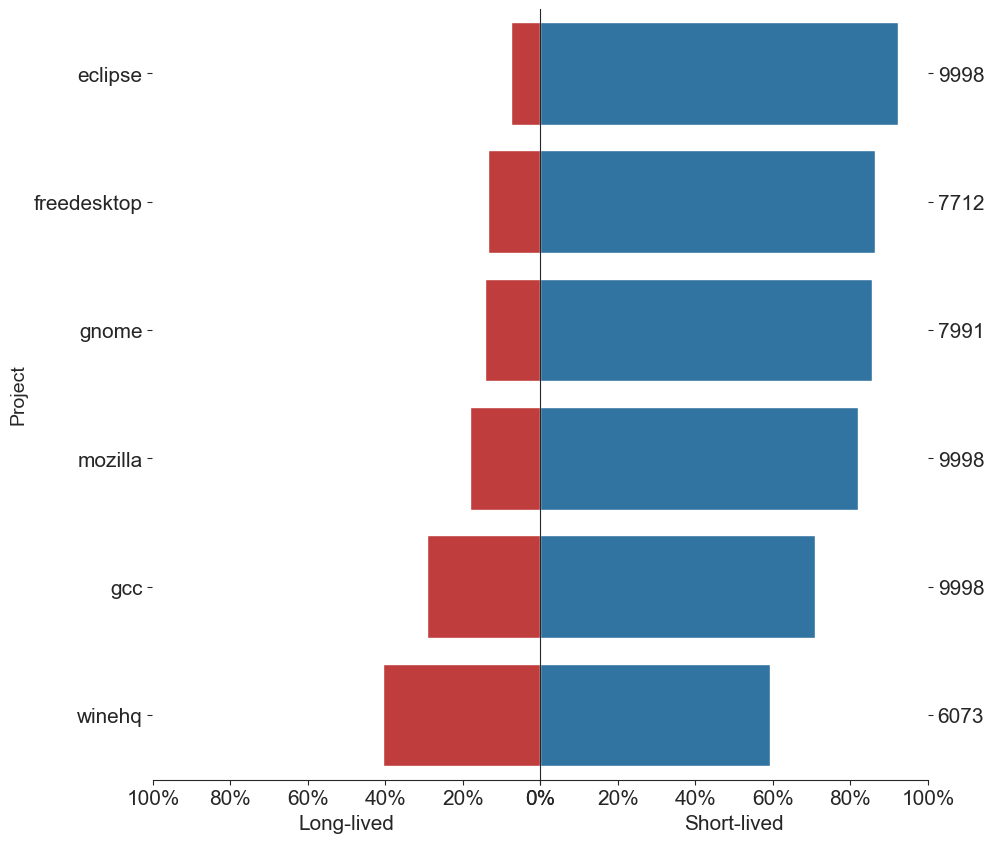

In [13]:
plot_pyramid(bug_reports_all_data, 'project', 'rq2-all-percentage-of-long-lived-bugs.pdf')